In [12]:
import torch##
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import sys
import time
import seaborn as sns
from sklearn.metrics import confusion_matrix
import os
from matplotlib import rcParams
rcParams['font.family'] = 'Times New Roman'

In [13]:
home_directory = os.path.expanduser('~')
onedrive_folder_name = 'OneDrive'
onedrive_path = os.path.join(home_directory, onedrive_folder_name)

root = os.path.join(onedrive_path, 'CODES', 'samples', 'cifar10_data')

transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5),
                         (0.5, 0.5, 0.5))
])#<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<


cifar10_train = datasets.CIFAR10(root=root, download=True, train=True, transform=transform)
cifar10_test = datasets.CIFAR10(root=root, download=True, train=False, transform=transform)

train_dataloader = DataLoader(cifar10_train, batch_size=100, shuffle=True)
test_dataloader = DataLoader(cifar10_test, batch_size=100, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [14]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    print("GPU name:", torch.cuda.get_device_name(0))
else:
    device = torch.device('cpu')
print(f'Using device: {device}')

Using device: cpu


In [15]:
class CNN(nn.Module):
    def __init__(self,img_size,channels):
        super(CNN, self).__init__()
        # 入力3チャネル(RGB) -> 出力32チャネル
        self.conv1 = nn.Conv2d(channels, 32, kernel_size=3, padding=1)
        # 32チャネル -> 64チャネル
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        # プーリング層
        self.pool = nn.MaxPool2d(2, 2)
        # 全結合層
        # CIFAR-10は 32x32 ⇒ conv, poolを2回通すと (64, 8, 8)
        self.fc1 = nn.Linear(64 * 8 * 8, 256)
        self.fc2 = nn.Linear(256, 10)  # 10クラス

        self.func = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.func(self.conv1(x)))       # conv1 → ReLU
        x = self.pool(self.func(self.conv2(x)))  # conv2 → ReLU → Pool
        x = x.view(x.size(0), -1)  # フラット化 (batch, 64*8*8)= nn.MaxPool2d(2, 2)
        # 全結合層
        x = self.func(self.fc1(x))          # 全結合1 → ReLU
        x = self.fc2(x)              # 全結合2 (出力)
        return x


1/5th Time Epoch: 20/20

Test Accuracy: 75.99%
loss_train: 0.5877,loss_test: 0.7115
LOSS:0.7115
ProcessingTime: 597.9126603603363


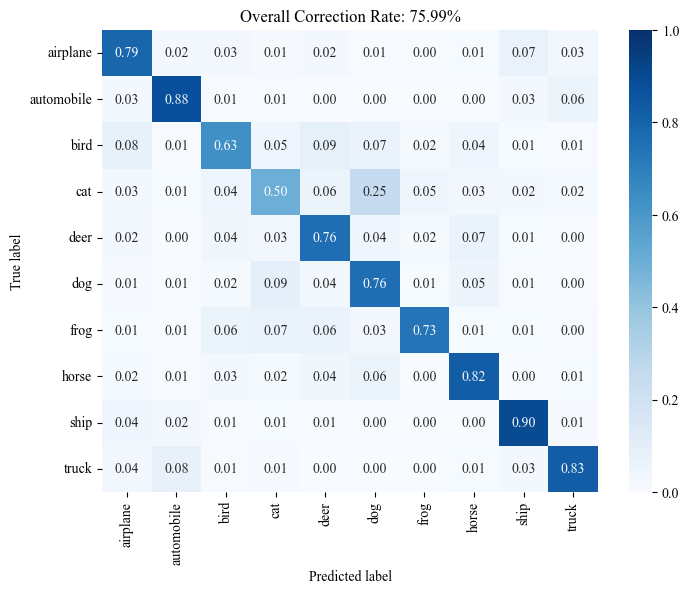

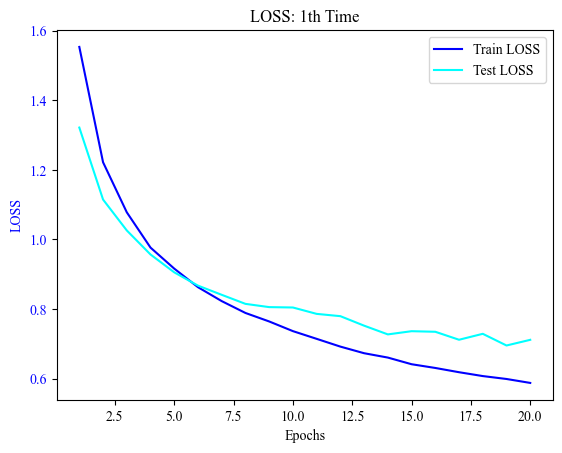

2/5th Time Epoch: 20/20

Test Accuracy: 76.17%
loss_train: 0.6130,loss_test: 0.6978
LOSS:0.6978
ProcessingTime: 706.7453093528748


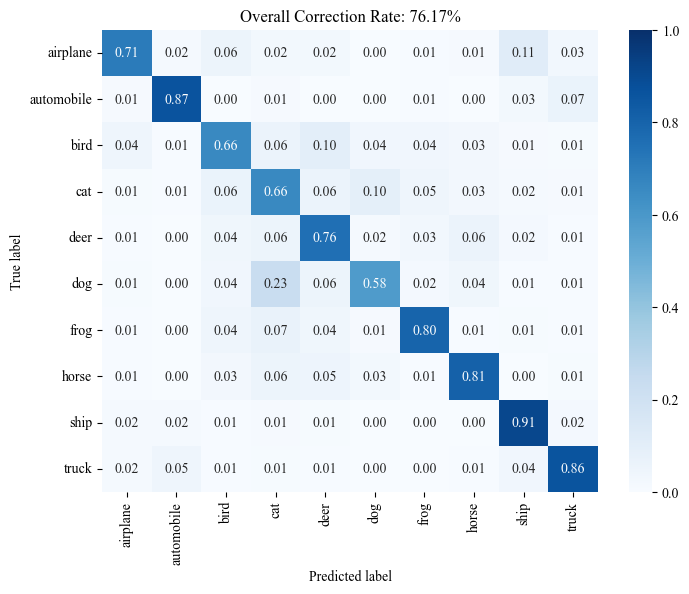

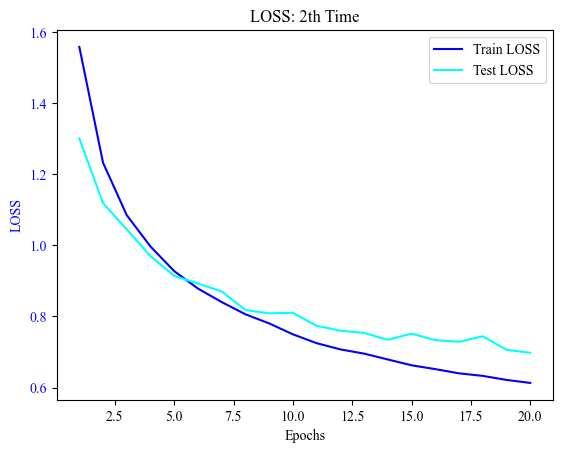

3/5th Time Epoch: 20/20

Test Accuracy: 75.22%
loss_train: 0.6167,loss_test: 0.7210
LOSS:0.7210
ProcessingTime: 582.4735469818115


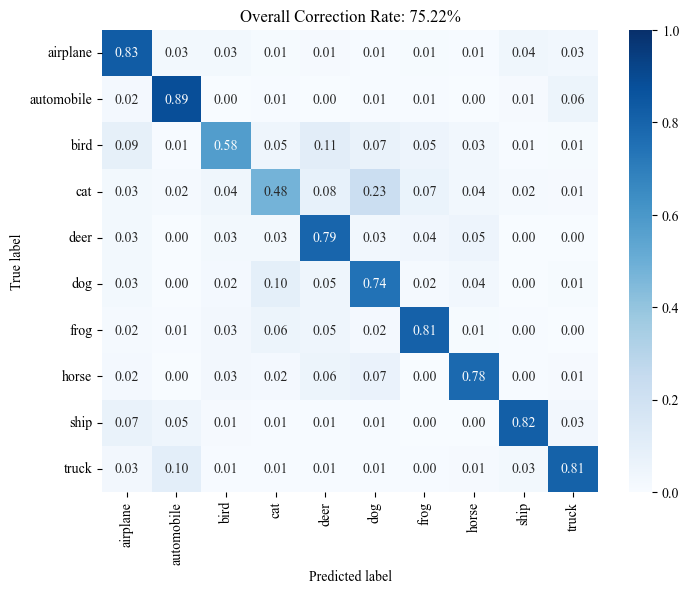

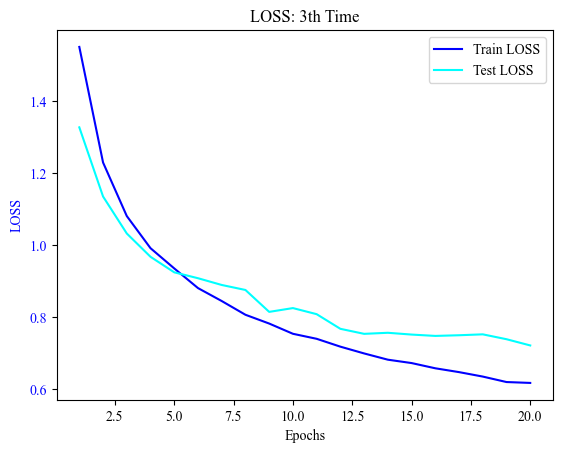

4/5th Time Epoch: 20/20

Test Accuracy: 75.41%
loss_train: 0.6129,loss_test: 0.7212
LOSS:0.7212
ProcessingTime: 573.3968534469604


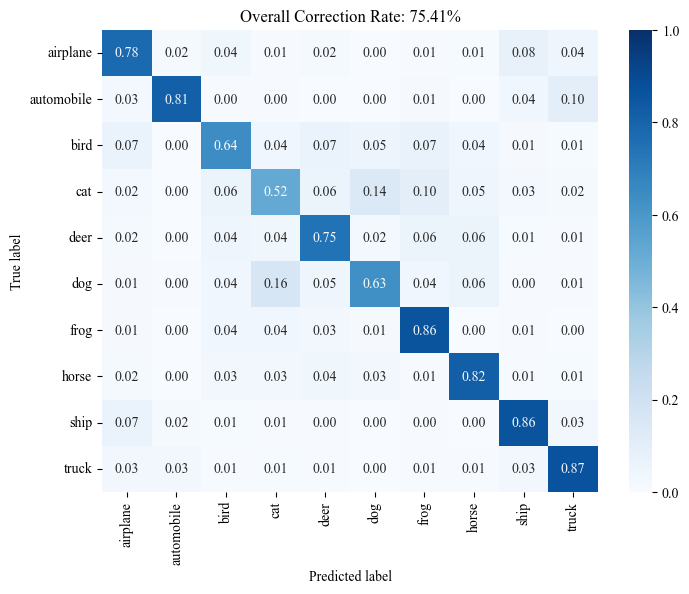

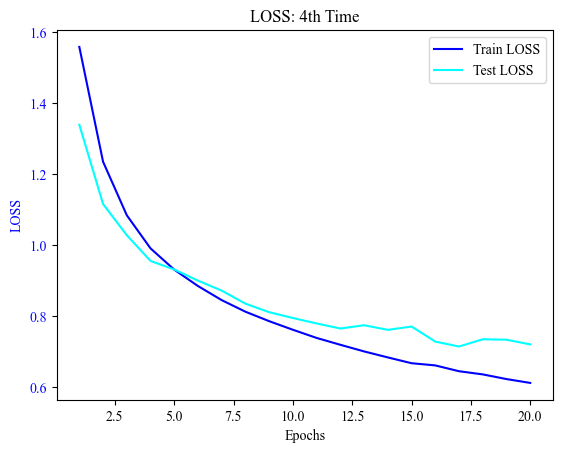

5/5th Time Epoch: 20/20

Test Accuracy: 76.66%
loss_train: 0.5989,loss_test: 0.6968
LOSS:0.6968
ProcessingTime: 579.5975494384766


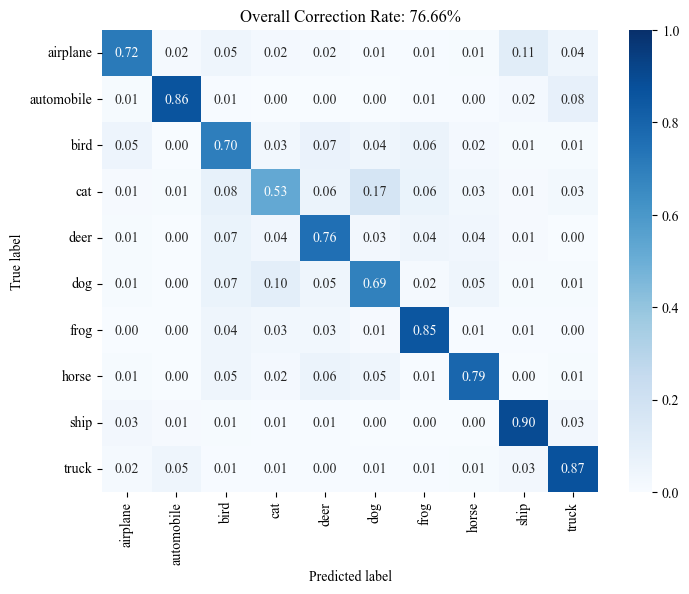

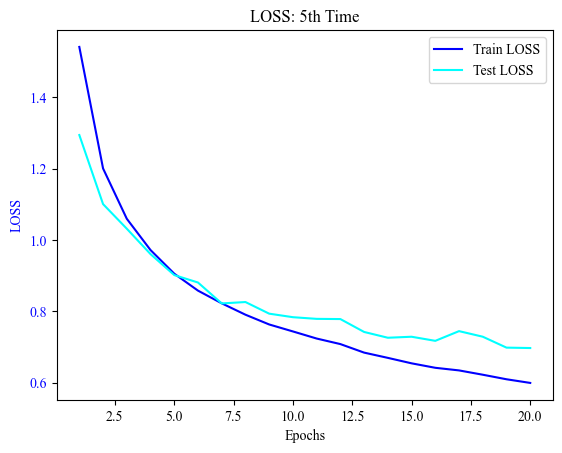

In [16]:
channels = 3
img_size = 32
max_epochs = 20##10

num_try = 5##5

All_last_loss = []
All_loss_test = []
All_pro_time = []
All_test_acc = []

for num_times in range(num_try): 

    model = CNN(img_size,channels).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    
    loss_train_ = []
    loss_test_ = []
    pro_time_ = []

            
    for epoch in range(max_epochs):

        sys.stderr.write('\r%d/%dth Time Epoch: %d/%d' % (num_times+1,num_try, epoch+1, max_epochs)) 
        sys.stderr.flush()

        loss_train = 0
        loss_test = 0

        start_time1 = time.time()
        for (x,t) in train_dataloader:
                    
            x, t = x.to(device), t.to(device)
            y = model(x).to(device)
            loss = criterion(y, t) 
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_train += loss.item()

       
        loss_train_avg = loss_train / len(train_dataloader)
        end_time1 = time.time()
        pro_time_.append(end_time1-start_time1)

        model.eval()
        with torch.no_grad():
            all_preds = []
            all_labels = []
            correct = 0
            total = 0
            for x, t in test_dataloader:
                x, t = x.to(device), t.to(device)
                y = model(x).to(device)
                _, predicted = torch.max(y, 1)
                loss = criterion(y,t)
                loss_test += loss.item()        
                total += t.size(0)
                correct += (predicted == t).sum().item()
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(t.cpu().numpy()) 
        
        #print(f"Test Accuracy: {100 * correct / total:.2f}%")
        loss_test_avg = loss_test / len(test_dataloader)

        loss_train_.append(loss_train_avg)
        loss_test_.append(loss_test_avg)
        #if epoch == max_epochs-1:
    All_loss_test.append(loss_test_)
    All_pro_time.append(sum(pro_time_)) 

    cm = confusion_matrix(all_labels, all_preds)
    cm = cm.astype('float') / cm.sum(axis=1, keepdims=True)  # 正規化（行ごとに割合に）

    Last_loss_test = loss_test_[-1]
    All_last_loss.append(Last_loss_test)
    All_test_acc.append(100 * correct / total)
    print(f"Test Accuracy: {100 * correct / total:.2f}%")
    print(f"loss_train: {loss_train_avg:.4f},loss_test: {loss_test_avg:.4f}")
    print(f"LOSS:{Last_loss_test:.4f}")
    print('ProcessingTime:',sum(pro_time_))
    class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
                    'dog', 'frog', 'horse', 'ship', 'truck']
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues", xticklabels=class_names, yticklabels=class_names,vmin=0.0, vmax=1.0)
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.title(f"Overall Correction Rate: {100 * correct / total:.2f}%")
    plt.show()

    fig, ax1 = plt.subplots()
    ax1.plot(range(1,len(loss_train_)+1), loss_train_, label="Train LOSS", color = 'blue')
    ax1.plot(range(1,len(loss_test_)+1), loss_test_, label="Test LOSS", color = 'cyan')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('LOSS', color = 'blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    ax1.legend()

    title = 'LOSS: %dth Time'%(num_times+1) #
    plt.title(title)
    plt.show()


In [17]:
ACC_mean = np.mean(All_test_acc)
ACC_best = np.max(All_test_acc)
ACC_bestID = np.argmax(All_test_acc)+1
ACC_worst = np.min(All_test_acc)
ACC_worstID = np.argmin(All_test_acc)+1

LOSS_mean = np.mean(All_last_loss)
LOSS_best = np.min(All_last_loss)
LOSS_bestID = np.argmin(All_last_loss)+1
LOSS_worst = np.max(All_last_loss)
LOSS_worstID = np.argmax(All_last_loss)+1

data = {
        "": ["ACC", "LOSS"],
    "Average": [ACC_mean, LOSS_mean],
    "Best ID": [ACC_bestID, LOSS_bestID],
    "Best": [ACC_best, LOSS_best],
    "Worst ID": [ACC_worstID, LOSS_worstID],
    "Worst": [ACC_worst, LOSS_worst],
}

df = pd.DataFrame(data)

print(df)


          Average  Best ID       Best  Worst ID      Worst
0   ACC  75.89000        5  76.660000         3  75.220000
1  LOSS   0.70966        5   0.696813         4   0.721201


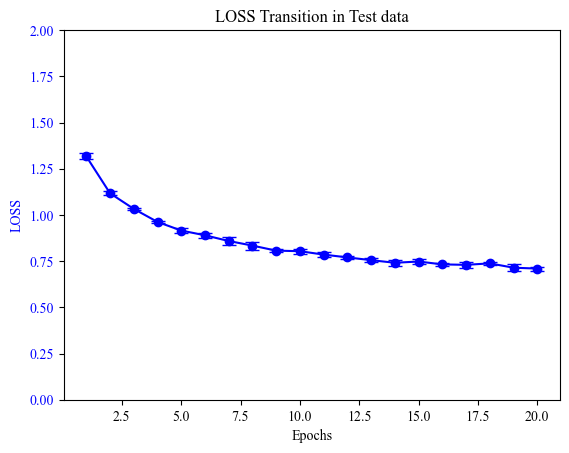

In [18]:
epochs = len(All_loss_test[0])  # エポック数（各リストの長さ）
num_dimensions = len(All_loss_test)  # 埋め込み次元数の数

# 各エポックごとに平均と標準偏差を計算
mean_loss = np.mean(All_loss_test, axis=0)
std_loss = np.std(All_loss_test, axis=0)

# グラフの描画
fig, ax1 = plt.subplots()

# 平均値の折れ線グラフと誤差範囲（標準偏差の誤差棒）
ax1.errorbar(
    x=range(1, epochs + 1), y=mean_loss, yerr=std_loss,
    fmt='-o', color='blue', ecolor='blue', capsize=5, 
)

# 軸ラベルやタイトルの設定
ax1.set_xlabel('Epochs')
ax1.set_ylabel('LOSS', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
plt.title('LOSS Transition in Test data')
plt.ylim(0,2.0)
plt.show()

In [19]:
import csv
save_directory1 = os.path.join(onedrive_path,'CODES', 'konishi_AutoEncoder', 'AutoEncoder_data005','texts') 
print(save_directory1)
os.makedirs(save_directory1, exist_ok=True)
file_name = 'CNN_CIFAR10_Class00_list.csv'##
full_path = os.path.join(save_directory1, file_name)
with open(full_path, mode='w', newline='') as file:
    writer = csv.writer(file)

    writer.writerow(All_loss_test)

/Users/konishi/OneDrive/CODES/konishi_AutoEncoder/AutoEncoder_data005/texts
